# Proximity and Accessibility analysis using Pandana

## Set up environment

In [38]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # disable Pandana multithreading 
os.environ["USE_PYGEOS"] = "0"  # suppress geopandas warning

import pandana
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

## Data Loading

We will load data from the following path on Spider: `/project/stursdat/Data/ScalableGIS/Part2/data_9_cities`. We use the `pathlib.Path` library to handle the path object.

In [39]:
from pathlib import Path

data_folder = Path("data")

# list_cities = ["Delft", "Arnhem"] # For debugging
list_cities = [ "Arnhem", "Breda", "Nijmegen", "Delft", "Amersfoort", "Leiden", "Enschede", "Deventer", "Gouda"]


In [40]:
import dask.bag as db
bags = db.from_sequence(list_cities, npartitions=2)

In [41]:
def load_one_city(city, data_folder):
    dir_city = data_folder / city
    nodes = gpd.read_file(next(dir_city.glob('*nodes*.shp'))) # We know there is only one result, so we use the "next" 
    edges = gpd.read_file(next(dir_city.glob('*edges*.shp')))
    parks = gpd.read_file(next(dir_city.glob('*parks*.shp')))
    buildings = gpd.read_file(next(dir_city.glob('*buildings*.shp')))

    # Return a dictionary of the city
    return {"nodes": nodes, "edges": edges, "parks":parks, "buildings": buildings}

In [42]:
# Load shape files to memory
gdf_cities = bags.map(load_one_city, data_folder).compute()

In [43]:
gdf_cities

[{'nodes':              osmid              x              y   
  0         34964022  188304.818961  445255.978650  \
  1         34964030  187923.400941  445094.554482   
  2         34964033  187862.702263  445011.531961   
  3         34964037  187809.501107  444995.482793   
  4         44481135  190237.664802  438730.750038   
  ...            ...            ...            ...   
  18234  10888096683  190781.170411  443090.534148   
  18235  10888103250  191328.835922  444459.632584   
  18236  10888103256  191346.706712  444409.183407   
  18237  10888128913  190219.005670  443413.830553   
  18238  10888177836  190555.686468  443186.553731   
  
                              geometry  
  0      POINT (188304.819 445255.979)  
  1      POINT (187923.401 445094.554)  
  2      POINT (187862.702 445011.532)  
  3      POINT (187809.501 444995.483)  
  4      POINT (190237.665 438730.750)  
  ...                              ...  
  18234  POINT (190781.170 443090.534)  
  18235  POI

In [44]:
def build_network_one_city(gdf_city):
    # Unpack dictionary
    nodes = gdf_city["nodes"]
    edges = gdf_city["edges"]
    parks = gdf_city["parks"]

    # Set indexes for nodes and edges
    nodes = nodes.set_index("osmid", drop=False)
    edges = edges.set_index(["u", "v"], drop=False)

    # setup a network
    network = pandana.Network(
        node_x=nodes["x"], 
        node_y=nodes["y"], 
        edge_from=edges["u"], 
        edge_to=edges["v"], 
        edge_weights=edges[["length"]],
    )

    network.set_pois(
        category="parks",
        maxdist=1000,
        maxitems=25,
        x_col=parks.centroid.x,
        y_col=parks.centroid.y,
    )
    
    return network

## Proximity analysis 

In [45]:
def nearest_pois_one_city(gdf_city):
    # build network
    network = build_network_one_city(gdf_city)    

    # for all nodes, find 3 closest parks within 800m
    results = network.nearest_pois(
        distance=800,
        category="parks",
        num_pois=3,
        include_poi_ids=False
    )

    return results

In [46]:
bags = db.from_sequence(gdf_cities, npartitions=2)
results_cities = bags.map(nearest_pois_one_city).compute()

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 18239
Setting CH edge vector of size 52962
Range graph removed 54946 edges of 105924
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 13493
Setting CH edge vector of size 38806
Range graph removed 40312 edges of 77612
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 11756
Setting CH edge vector of size 33908
Range graph removed 35350 edges of 67816
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 9762
Setting CH edge vector of size 27352
Range graph removed 28274 edges of 54704
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 8908
Setti

In [47]:
results_cities

[                      1           2           3
 osmid                                          
 34964022      75.267998  111.698997  222.931000
 34964030       0.000000   96.403999   96.403999
 34964033       0.000000  112.732002  209.136002
 34964037      55.407001  168.139008  264.542999
 44481135       0.000000    0.000000   94.663002
 ...                 ...         ...         ...
 10888096683    0.000000  565.844971  751.244019
 10888103250  163.123993  188.126999  198.996002
 10888103256  107.024002  142.895996  218.619003
 10888128913    0.000000   75.709000   75.709000
 10888177836  324.161011  382.707001  798.271973
 
 [18239 rows x 3 columns],
                       1           2           3
 osmid                                          
 42844188       0.000000    0.000000    0.000000
 42848516       0.000000    0.000000    0.000000
 42888243       0.000000  130.447006  130.447006
 42888484     130.983994  261.431000  261.431000
 42907287       0.000000    0.000000    

## Accessibility analysis

In [48]:
def accessible_analysis_one_city(gdf_city):

    # build network
    network = build_network_one_city(gdf_city)

    # Unpack dictionary
    parks = gdf_city["parks"]
    buildings = gdf_city["buildings"]

    # add target points to network
    node_ids = network.get_node_ids(parks.centroid.x, y_col=parks.centroid.y)
    network.set(node_ids, name="parks")

    # for all nodes, find how many parks fall within 800m
    accessibility = network.aggregate(
        distance=800,
        type="count",
        name="parks"
    )

    # assign accessibility of buildings using closest nodes 
    node_ids = network.get_node_ids(
        x_col=buildings.centroid.x, 
        y_col=buildings.centroid.y
    )
    buildings["accessibility"] = node_ids.map(accessibility.to_dict())

    return [accessibility, buildings]

In [49]:
bags = db.from_sequence(gdf_cities, npartitions=2)
accessibility_cities = bags.map(accessible_analysis_one_city).compute()

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 18239
Setting CH edge vector of size 52962
Range graph removed 54946 edges of 105924
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 13493
Setting CH edge vector of size 38806
Range graph removed 40312 edges of 77612
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 11756
Setting CH edge vector of size 33908
Range graph removed 35350 edges of 67816
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 9762
Setting CH edge vector of size 27352
Range graph removed 28274 edges of 54704
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 8908
Setti

In [50]:
len(accessibility_cities)

9

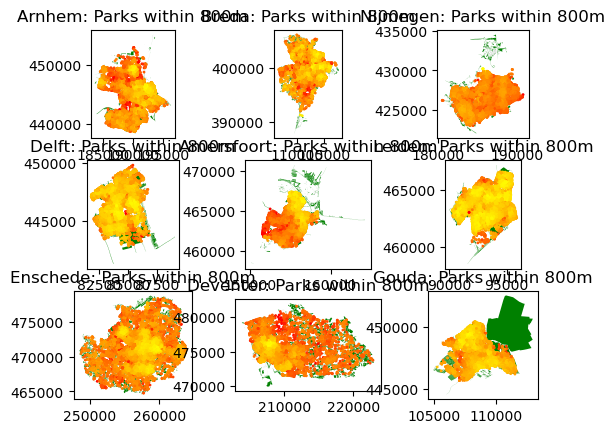

In [51]:
# visualize nodes using accessibility
# fig, axes = plt.subplots(2, 1) # for debugging
# for ax, city, gdf, accessibility in zip(axes, list_cities, gdf_cities, accessibility_cities): # for debugging
fig, axes = plt.subplots(3, 3)
for ax, city, gdf, accessibility in zip(axes.flatten(), list_cities, gdf_cities, accessibility_cities):
    parks = gdf["parks"]
    nodes = gdf["nodes"]
    parks.plot(
        ax=ax,
        color="green"
    )
    ax.set_title('{}: Parks within 800m'.format(city))
    ax.scatter(
        nodes["x"], 
        nodes["y"], 
        c=accessibility[0], 
        s=1, 
        cmap='autumn', 
        norm=matplotlib.colors.LogNorm()
    )

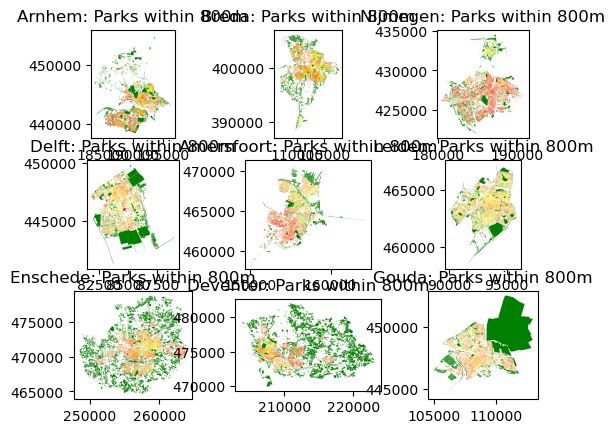

In [52]:
# visualize buildings using accessibility
# fig, axes = plt.subplots(2, 1) # for debugging
# for ax, city, gdf, accessibility in zip(axes, list_cities, gdf_cities, accessibility_cities): # for debugging
fig, axes = plt.subplots(3, 3)
for ax, city, gdf, accessibility in zip(axes.flatten(), list_cities, gdf_cities, accessibility_cities):
    parks = gdf["parks"]
    buildings = accessibility[1]

    ax.set_title('{}: Parks within 800m'.format(city))
    
    parks.plot(
    ax=ax,
    color="green"
    )
    
    buildings.plot(
        ax=ax,
        column="accessibility",  
        cmap="autumn",
        norm=matplotlib.colors.LogNorm(),
        figsize=(10,8),
    )